# Objective

The purpose of this notebook is to test Pyro with MCMC in a simple case involving a linear Gaussian BN.

In [1]:
import sys
import time
from pathlib import Path

import torch
import pyro
import pyro.distributions as dist
from pyro.infer import MCMC, NUTS
from pyro.optim import Adam
from pyro import poutine
from pgmpy.models import LinearGaussianBayesianNetwork
from pgmpy.factors.continuous import LinearGaussianCPD

# Set the base path
base_path = Path("../../")  # One level up from the current working directory

# Add the src/ directory to sys.path using base_path
sys.path.append(str((base_path / "src").resolve()))

from bn_utils import draw_bayesian_network
from continuous.gaussian_inference import inference
from continuous.pgmpy_to_joint_gaussian import pgmpy_to_joint_gaussian 

## Create BN with defined structure and random parameters

In [2]:
def create_cancer_model(use_random=False):
    """
    Create the Linear Gaussian Bayesian Network with either random or specific parameters.
    
    Args:
        use_random (bool): If True, use random parameters. If False, use predefined parameters.
    
    Returns:
        model: LinearGaussianBayesianNetwork with CPDs set
        cpds_dict: Dictionary mapping variable names to their CPDs
    """
    
    # Create the model structure
    model = LinearGaussianBayesianNetwork([
        ("Pollution", "Cancer"),
        ("Smoker", "Cancer"),
        ("Cancer", "Xray"),
        ("Cancer", "Dyspnoea"),
    ])
    
    if use_random:
        # Use random parameters
        model.get_random_cpds(inplace=True)
        print("Created model with random parameters")
    else:
        
        # P(Pollution) = N(0.305; 1.04)
        pollution_cpd = LinearGaussianCPD('Pollution', [0.305], 1.04)
        
        # P(Smoker) = N(1.446; 0.102)
        smoker_cpd = LinearGaussianCPD('Smoker', [1.446], 0.102)
        
        # P(Cancer | Pollution, Smoker) = N(0.678*Pollution + -0.586*Smoker + 0.244; 0.909)
        cancer_cpd = LinearGaussianCPD('Cancer', [0.244, 0.678, -0.586], 0.909, 
                                      evidence=['Pollution', 'Smoker'])
        
        # P(Xray | Cancer) = N(-0.623*Cancer + -0.458; 0.135)
        xray_cpd = LinearGaussianCPD('Xray', [-0.458, -0.623], 0.135, 
                                    evidence=['Cancer'])
        
        # P(Dyspnoea | Cancer) = N(1.218*Cancer + -0.503; 0.271)
        dyspnoea_cpd = LinearGaussianCPD('Dyspnoea', [-0.503, 1.218], 0.271, 
                                        evidence=['Cancer'])
        
        # Add CPDs to model
        model.add_cpds(pollution_cpd, smoker_cpd, cancer_cpd, xray_cpd, dyspnoea_cpd)
        print("Created model with predefined parameters")
    
    # Verify model
    assert model.check_model(), "Model validation failed"
    
    # Create CPDs dictionary
    cpds_dict = {cpd.variable: cpd for cpd in model.get_cpds()}
    
    # Display model info
    nodes = model.nodes()
    edges = model.edges()
    cpds = model.get_cpds()
    
    cpd_strings = []
    for cpd in cpds:
        cpd_strings.append(str(cpd))
    
    cpds_as_string = "\n".join(cpd_strings)
    
    print(f"\nNodes in the model: {nodes}")
    print(f"Edges in the model: {edges}")
    print(f"CPDs in the model:")
    print(cpds_as_string)
    
    return model, cpds_dict

In [3]:
# Create model with predefined parameters
model, cpds_dict = create_cancer_model(use_random=False)

# Or create with random parameters:
# model, cpds_dict = create_cancer_model(use_random=True)

Created model with predefined parameters

Nodes in the model: ['Pollution', 'Cancer', 'Smoker', 'Xray', 'Dyspnoea']
Edges in the model: [('Pollution', 'Cancer'), ('Cancer', 'Xray'), ('Cancer', 'Dyspnoea'), ('Smoker', 'Cancer')]
CPDs in the model:
P(Pollution) = N(0.305; 1.04)
P(Smoker) = N(1.446; 0.102)
P(Cancer | Pollution, Smoker) = N(0.678*Pollution + -0.586*Smoker + 0.244; 0.909)
P(Xray | Cancer) = N(-0.623*Cancer + -0.458; 0.135)
P(Dyspnoea | Cancer) = N(1.218*Cancer + -0.503; 0.271)


## Draw the structure

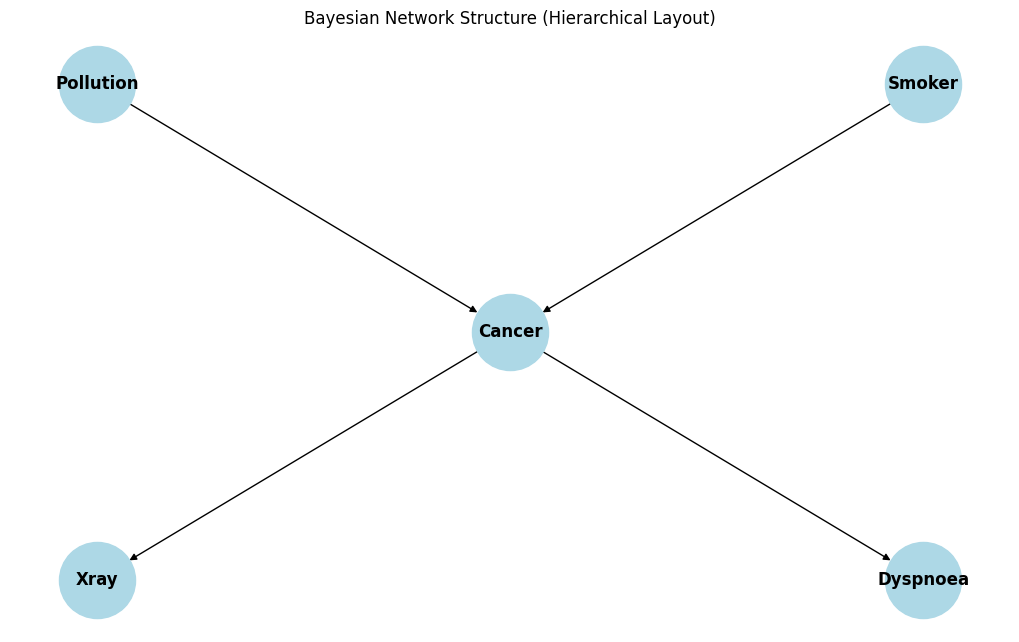

In [4]:
draw_bayesian_network(model)

## Inference

We are going to test a simple query: <code>P(Pollution | Dyspnoea = 0.5)</code>

### Exact

In [5]:
# Convert the Linear Gaussian BN to joint Gaussian representation
mean, cov, variable_names = pgmpy_to_joint_gaussian(model)

print("Joint Gaussian Distribution:")
print(f"Variables: {variable_names}")
print(f"Mean vector: {mean}")
print(f"Covariance matrix shape: {cov.shape}")
print()


Joint Gaussian Distribution:
Variables: ['Pollution', 'Smoker', 'Cancer', 'Xray', 'Dyspnoea']
Mean vector: [ 0.305       1.446      -0.396566   -0.21093938 -0.98601739]
Covariance matrix shape: (5, 5)



In [6]:
exact_result = inference(mean, cov, variable_names, 'Pollution', evidence={'Dyspnoea': 0.5})
print("Query: P(Pollution | Dyspnoea = 0.5)")
print(f"Mean: {exact_result['mean']:.4f}")
print(f"Std: {exact_result['std']:.4f}")
print()

Query: P(Pollution | Dyspnoea = 0.5)
Mean: 0.9550
Std: 0.8312



### MCMC (with NUTS)

In [7]:
def create_pyro_model_for_mcmc(model):
    """
    Convert pgmpy LinearGaussianBayesianNetwork to a simple Pyro model for MCMC.
    
    Uses the correct LinearGaussianCPD attributes:
    - cpd.beta: coefficients array [intercept, coeff1, coeff2, ...]
    - cpd.std: standard deviation (noise)
    - cpd.variables: [variable, parent1, parent2, ...]
    """
    
    # Extract parameters from pgmpy model
    params = {}
    for cpd in model.get_cpds():
        var = cpd.variable
        
        if len(cpd.variables) == 1:  # Root node (no parents)
            params[var.lower()] = {
                'mean': torch.tensor(cpd.beta[0], dtype=torch.float32),
                'std': torch.tensor(cpd.std, dtype=torch.float32)
            }
        else:  # Child node with parents
            parents = cpd.variables[1:]  # Skip the variable itself
            params[var.lower()] = {
                'intercept': torch.tensor(cpd.beta[0], dtype=torch.float32),
                'coeffs': torch.tensor(cpd.beta[1:], dtype=torch.float32),
                'std': torch.tensor(cpd.std, dtype=torch.float32),
                'parents': [p.lower() for p in parents]
            }
    
    def pyro_model():
        """Simple Pyro model for MCMC - no vectorization, no pyro.plate"""
        
        # Sample root nodes (no parents)
        pollution = pyro.sample("pollution", 
                              dist.Normal(params['pollution']['mean'], 
                                        params['pollution']['std']))
        smoker = pyro.sample("smoker", 
                           dist.Normal(params['smoker']['mean'], 
                                     params['smoker']['std']))
        
        # Sample Cancer (depends on Pollution and Smoker)  
        cancer_mean = (params['cancer']['intercept'] + 
                      params['cancer']['coeffs'][0] * pollution +    # Pollution coefficient
                      params['cancer']['coeffs'][1] * smoker)        # Smoker coefficient
        cancer = pyro.sample("cancer", dist.Normal(cancer_mean, params['cancer']['std']))
        
        # Sample Xray (depends on Cancer)
        xray_mean = (params['xray']['intercept'] + 
                    params['xray']['coeffs'][0] * cancer)
        xray = pyro.sample("xray", dist.Normal(xray_mean, params['xray']['std']))
        
        # Sample Dyspnoea (depends on Cancer)
        dyspnoea_mean = (params['dyspnoea']['intercept'] + 
                       params['dyspnoea']['coeffs'][0] * cancer)
        dyspnoea = pyro.sample("dyspnoea", dist.Normal(dyspnoea_mean, params['dyspnoea']['std']))
        
        return {"pollution": pollution, "smoker": smoker, "cancer": cancer, 
                "xray": xray, "dyspnoea": dyspnoea}
    
    return pyro_model, params

In [8]:
# Create the Pyro model for MCMC
pyro_model, pyro_params = create_pyro_model_for_mcmc(model)

print("Pyro model for MCMC created successfully!")
print("\nExtracted parameters from pgmpy LinearGaussianCPDs:")
for var, param_dict in pyro_params.items():
    print(f"{var.upper()}: {param_dict}")

Pyro model for MCMC created successfully!

Extracted parameters from pgmpy LinearGaussianCPDs:
POLLUTION: {'mean': tensor(0.3050), 'std': tensor(1.0400)}
SMOKER: {'mean': tensor(1.4460), 'std': tensor(0.1020)}
CANCER: {'intercept': tensor(0.2440), 'coeffs': tensor([ 0.6780, -0.5860]), 'std': tensor(0.9090), 'parents': ['pollution', 'smoker']}
XRAY: {'intercept': tensor(-0.4580), 'coeffs': tensor([-0.6230]), 'std': tensor(0.1350), 'parents': ['cancer']}
DYSPNOEA: {'intercept': tensor(-0.5030), 'coeffs': tensor([1.2180]), 'std': tensor(0.2710), 'parents': ['cancer']}


#### Inference

In [9]:
def run_mcmc_inference(pyro_model, query_var, evidence_dict, device_name="cpu", num_samples=1000, warmup_steps=200):
    """
    Run MCMC inference on specified device (CPU or GPU).
    """
    # Set device
    device = torch.device(device_name)
    
    # Move evidence to device
    if evidence_dict:
        evidence_tensors = {k: torch.tensor(v, dtype=torch.float32, device=device) 
                           for k, v in evidence_dict.items()}
        conditioned_model = poutine.condition(pyro_model, data=evidence_tensors)
    else:
        conditioned_model = pyro_model
    
    # Clear param store and set up MCMC
    pyro.clear_param_store()
    nuts_kernel = NUTS(conditioned_model, adapt_step_size=True, max_tree_depth=10)
    mcmc = MCMC(nuts_kernel, num_samples=num_samples, warmup_steps=warmup_steps, num_chains=1)
    
    # Time the inference
    start_time = time.time()
    mcmc.run()
    end_time = time.time()
    
    # Get results
    samples_dict = mcmc.get_samples()
    samples = samples_dict[query_var]
    
    return {
        'samples': samples,
        'mean': samples.mean().item(),
        'std': samples.std().item(),
        'runtime': end_time - start_time,
        'device': device_name
    }

In [10]:
# Run the same inference query using MCMC: P(Pollution | Dyspnoea = 0.5)
evidence = {'dyspnoea': 0.5}
query_var = 'pollution'

print("=== MCMC Inference using NUTS ===")
mcmc_result = run_mcmc_inference(pyro_model, query_var, evidence, num_samples=2000, warmup_steps=500)

print(f"\nQuery: P({query_var.title()} | Dyspnoea = {evidence['dyspnoea']})")
print(f"MCMC Mean: {mcmc_result['mean']:.4f}")
print(f"MCMC Std:  {mcmc_result['std']:.4f}")

print(f"\n=== Comparison ===")
print(f"Exact inference - Mean: {exact_result['mean']:.4f}, Std: {exact_result['std']:.4f}")
print(f"MCMC inference  - Mean: {mcmc_result['mean']:.4f}, Std: {mcmc_result['std']:.4f}")

=== MCMC Inference using NUTS ===


Sample: 100%|██████████| 2500/2500 [00:13, 188.16it/s, step size=5.60e-01, acc. prob=0.928]


Query: P(Pollution | Dyspnoea = 0.5)
MCMC Mean: 0.9633
MCMC Std:  0.8496

=== Comparison ===
Exact inference - Mean: 0.9550, Std: 0.8312
MCMC inference  - Mean: 0.9633, Std: 0.8496


### Compare GPU and CPU performance

In [11]:
# GPU vs CPU performance comparison for MCMC
print("GPU vs CPU Performance Comparison (MCMC)")
print("-" * 40)

evidence = {'dyspnoea': 0.5}
query_var = 'pollution'
devices = ["cpu", "cuda"] if torch.cuda.is_available() else ["cpu"]
times = {}
results = {}

for device_name in devices:
    print(f"\n{device_name.upper()}:")
    
    # Run MCMC inference on this device
    mcmc_result = run_mcmc_inference(
        pyro_model, query_var, evidence, 
        device_name=device_name, 
        num_samples=2000, 
        warmup_steps=500
    )
    
    times[device_name] = mcmc_result['runtime']
    results[device_name] = mcmc_result
    
    print(f"Time: {mcmc_result['runtime']:.3f}s")
    print(f"Result: Mean={mcmc_result['mean']:.4f}, Std={mcmc_result['std']:.4f}")

# Show speedup if both devices available
if len(devices) == 2:
    speedup = times["cpu"] / times["cuda"]
    print(f"\nSpeedup: GPU is {speedup:.2f}x faster than CPU")
else:
    print(f"\nGPU not available. Only CPU testing performed.")

GPU vs CPU Performance Comparison (MCMC)
----------------------------------------

CPU:


Sample: 100%|██████████| 2500/2500 [00:12, 208.02it/s, step size=5.97e-01, acc. prob=0.895]


Time: 12.020s
Result: Mean=0.9577, Std=0.8202

CUDA:


Sample: 100%|██████████| 2500/2500 [00:22, 109.57it/s, step size=4.79e-01, acc. prob=0.945]

Time: 22.818s
Result: Mean=0.9594, Std=0.8163

Speedup: GPU is 0.53x faster than CPU
